# More crunchers

In this notebook we will go through several more types of cruncher. This discussion may be easier to follow if you have read through the "Introduction to Crunchers" notebook, though the crunchers in it are independent. 

## Imports

In [1]:
import os.path
import traceback

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db,
    get_sr15_scenarios,
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Download example data

We obtain example data by downloading a selection of the SR1.5 scenarios from the IIASA database. If the data has already been downloaded before, we will use that instead for brevity.

In [2]:
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    # "IEA*",
    # "IMAGE*",
    # "MERGE*",
    # "POLES*",
    # "REMIND*",
    "WITCH*",
]
SR15_SCENARIOS = "./sr15_scenarios.csv"
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS, valid_model_ids)
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
sr15_data.timeseries().head()

pyam.utils - INFO: Reading `./sr15_scenarios.csv`


2000  \
model       scenario               region variable                                           unit      subannual meta         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0      NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      NaN   

                                                                                                                           2005  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       8.3367   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0     344.9167   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0     167.6717   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0       0.4732   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      11.2639   

                                                                                                                           2010  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       7.6408   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0     367.7457   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0     179.6356   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0       0.5168   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      11.1249   

                                                                                                                       2014  \
model       scenario               region variable                                           unit      subannual meta         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0      NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      NaN   

                                                                                                                           2015  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       7.2724   
                                          Emissions|CH4                                      Mt CH4/yr 0.0    

## Pre-filtering data
The crunchers use the relationships between variables in the infiller database, however these may depend on very different political and economic assumptions to the scenarios you wish to infill. It can therefore be helpful to feed only a subset of the downloaded data into the cruncher. This may be by leaving out models that make radically different assumptions to yours, or by selecting only scenarios that are similar in some way.

A simple way to filter for similarity is by completing SSP-labelled scenarios using only scenarios with the same SSP labelling. The silicone package has a function for detecting which of a group of scenarios creates an interpolation that best matches a dataset. Using this tool, we see that the CO$_2$-CH$_4$ relations in some SSP2 scenarios in the AIM data are more similar to SSP3/SSP1 data from MESSAGE models. Below you can see examples of how to use this. 

In [3]:
data_to_classify = sr15_data.filter(model="AIM/CGE 2.0", scenario="SSP2-34")
data_to_search = sr15_data.filter(model=["MESSAGE*", "WITCH*"])
possible_ssps = ["SSP1*", "SSP2*", "SSP3*", "SSP4*", "SSP5*"]
find_matching_scenarios(
    data_to_search,
    data_to_classify,
    "Emissions|CH4",
    ["Emissions|CO2"],
    possible_ssps,
)

('*', 'SSP2*')

You can break down results by models and scenarios at the same time:

In [4]:
possible_models = ["MESSAGE*", "WITCH*"]
find_matching_scenarios(
    data_to_search,
    data_to_classify,
    "Emissions|CH4",
    ["Emissions|CO2"],
    possible_ssps,
    possible_models,
)

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


('MESSAGE*', 'SSP2*')

The answer returned is a tuple with first the model filter (* if none selected), then the scenario filter. It's also possible to get the results back in numerical form (they are reported in increasing order of distance, so the top result is the closest). In the event that a model/scenario combination doesn't have any data, a warning is displayed and the 'distance' is reported as infinity. We see that in this case, SSP2 matches best. It's possible to quantify how much better:

In [5]:
find_matching_scenarios(
    data_to_search,
    data_to_classify,
    "Emissions|CH4",
    ["Emissions|CO2"],
    possible_ssps,
    return_all_info=True,
)

[(('*', 'SSP2*'), 14517.363294669907),
 (('*', 'SSP1*'), 16694.15692871151),
 (('*', 'SSP4*'), 20872.869446778583),
 (('*', 'SSP5*'), 25842.838070253136),
 (('*', 'SSP3*'), 48537.48868242615)]

In [6]:
find_matching_scenarios(
    data_to_search,
    data_to_classify,
    "Emissions|CH4",
    ["Emissions|CO2"],
    possible_ssps,
    possible_models,
    return_all_info=True,
)

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


[(('MESSAGE*', 'SSP2*'), 14355.2242005093),
 (('MESSAGE*', 'SSP1*'), 20613.855469029084),
 (('WITCH*', 'SSP4*'), 20872.869446778583),
 (('WITCH*', 'SSP2*'), 23523.40135904596),
 (('WITCH*', 'SSP5*'), 25842.838070253136),
 (('WITCH*', 'SSP1*'), 30654.276428870824),
 (('WITCH*', 'SSP3*'), 50374.83630278302),
 (('MESSAGE*', 'SSP3*'), 58008.89648047759),
 (('MESSAGE*', 'SSP4*'), inf),
 (('MESSAGE*', 'SSP5*'), inf)]

Here we see that specific SSP2 scenarios in some models do not necesssarily match up best with SSP2 scenarios in other models, and that SSP1 and 4 models may be a closer match in this space than SSP2 in WITCH models. 

In some cases, we may wish to ignore the initial differences and only look for the closest trendlines, i.e. match the differentials. This is equivalent to setting all initial values to the same number, then performing the above analysis. This can be done by setting the "use_change_not_abs" value to True. Unfortunately, this requires a slightly more consistent database than when using absolute values (as we must subtract the initial point).  

In [7]:
try:
    find_matching_scenarios(
        data_to_search,
        data_to_classify,
        "Emissions|CH4",
        ["Emissions|CO2"],
        possible_ssps,
        possible_models,
        return_all_info=True,
        use_change_not_abs=True,
    )
except KeyError as w:
    print("Key error for: ", w)

Key error for:  ('AIM/CGE 2.0', 'SSP2-34', 2015)


In [8]:
find_matching_scenarios(
    data_to_search.filter(year=2015, keep=False),
    data_to_classify.filter(year=2015, keep=False),
    "Emissions|CH4",
    ["Emissions|CO2"],
    possible_ssps,
    possible_models,
    return_all_info=True,
    use_change_not_abs=True,
)

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


[(('MESSAGE*', 'SSP1*'), 12997.66909603955),
 (('WITCH*', 'SSP5*'), 17260.059013121252),
 (('WITCH*', 'SSP4*'), 18136.618660962344),
 (('WITCH*', 'SSP2*'), 19634.197414024587),
 (('WITCH*', 'SSP1*'), 28837.13352613092),
 (('MESSAGE*', 'SSP2*'), 29675.62327576658),
 (('WITCH*', 'SSP3*'), 42931.63612144401),
 (('MESSAGE*', 'SSP3*'), 99308.44011621375),
 (('MESSAGE*', 'SSP4*'), inf),
 (('MESSAGE*', 'SSP5*'), inf)]

So in terms of differentials, SSP2 models do not match up very well. Since the original scenario was an SSP2 scenario, this shows that filtering by SSP value is not necessarily the most appropriate. We will use Message data to perform the later calculations. 

In [9]:
filtered_sr15 = sr15_data.filter(model="MESSAGE*")

## More crunchers
### Time-dependent ratio cruncher
This cruncher uses the 'time-dependent ratio' methodology. It is described by its docstring.

In [10]:
print(silicone.database_crunchers.DatabaseCruncherTimeDepRatio.__doc__)


    Database cruncher which uses the 'time-dependent ratio' technique.

    This cruncher derives the relationship between two variables by simply assuming
    that the follower timeseries is equal to the lead timeseries multiplied by a
    time-dependent scaling factor. The scaling factor is the ratio of the
    follower variable to the lead variable. If the database contains many such pairs,
    the scaling factor is the ratio between the means of the values. By default, the
    calculation will include only values where the lead variable takes the same sign
    (+ or -) in the infilling database as in the case infilled. This prevents getting
    negative values of emissions that cannot be negative. To allow cases where we
    have no data of the correct sign, set `same_sign = False` in `derive_relationship`.

    Once the relationship is derived, the 'filler' function will infill following:

    .. math::
        E_f(t) = s(t) * E_l(t)

    where :math:`E_f(t)` is emissions of the 

#### Infilling
This technique extracts only a single constant multiplier from all data fed in to the cruncher, so additional data does not radically change how it behaves. This cruncher works well for cases like splitting groups of gases into constituent parts (for which it is used in the multi-infiller decompose_collection_with_time_dep_ratio), but is less reliable for gases which may have negative emissions. 

In [11]:
# We need to only include scenarios with all data:
sr15_data_tdr = filtered_sr15.filter(
    scenario=filtered_sr15.filter(variable="Emissions|VOC").scenarios()
)

In [12]:
cruncher = silicone.database_crunchers.DatabaseCruncherTimeDepRatio(
    sr15_data_tdr
)
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)


            Filler function derived from :obj:`DatabaseCruncherTimeDepRatio`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled-in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf``.
            


c:\users\rlamboll\constraincode\silicone\src\silicone\database_crunchers\time_dep_ratio.py:105: RuntimeWarning: invalid value encountered in greater
  pos_inds = data_leader[year].values > 0
c:\users\rlamboll\constraincode\silicone\src\silicone\database_crunchers\time_dep_ratio.py:110: RuntimeWarning: Mean of empty slice
  data_follower[year].iloc[~pos_inds].values
c:\users\rlamboll\constraincode\silicone\src\silicone\database_crunchers\time_dep_ratio.py:111: RuntimeWarning: Mean of empty slice
  ) / np.nanmean(data_leader[year].iloc[~pos_inds].values)


In [13]:
filler_data = data_to_classify.filter(variable=["Emissions|CO2"])
filler_data = filler_data.filter(year=filtered_sr15["year"].unique())
filler_data.data

,model,scenario,region,variable,unit,year,subannual,meta,value
66072,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2005,0.0,0,34373.9345
66073,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2010,0.0,0,38251.8756
66074,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2020,0.0,0,43231.2477
66075,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2030,0.0,0,38732.6422
66076,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2040,0.0,0,31243.5853
66077,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2050,0.0,0,23706.9432
66078,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2060,0.0,0,17488.1653
66079,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2070,0.0,0,12730.6701
66080,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2080,0.0,0,9444.6482
66081,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2090,0.0,0,6695.9765


In [14]:
results = filler(filler_data)
results.head()

,model,scenario,region,variable,unit,year,subannual,meta,value
0,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2005,0.0,0,179.812508
1,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2010,0.0,0,181.936050
2,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2020,0.0,0,187.377500
3,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2030,0.0,0,177.988676
4,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2040,0.0,0,157.738311


pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


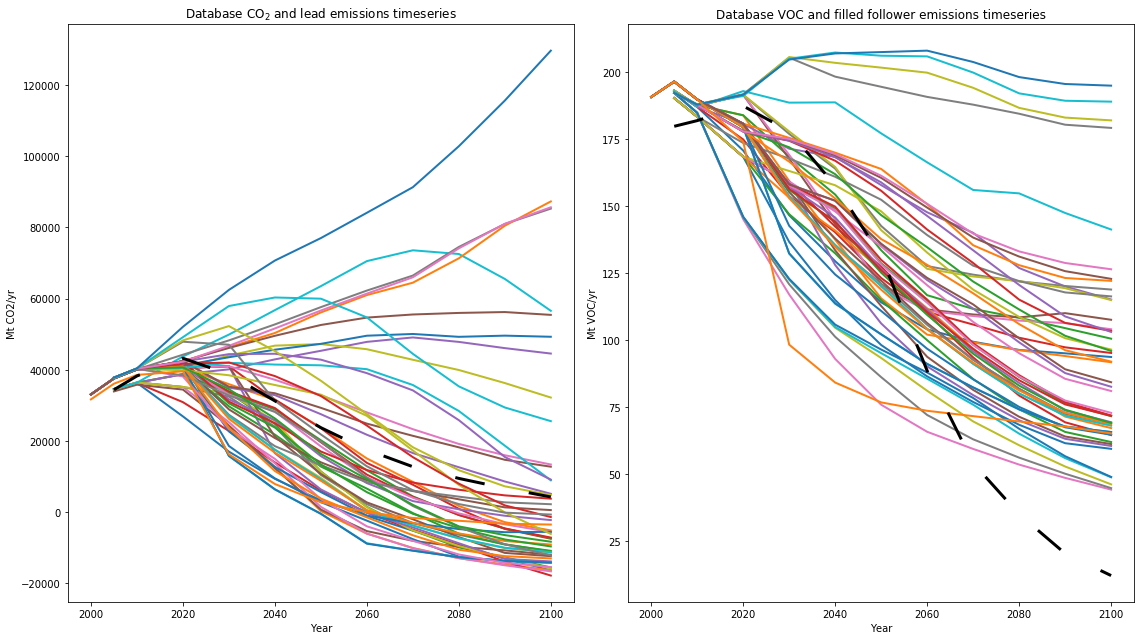

In [15]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), linewidth=3
)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_tdr.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
results.filter(variable="*VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), linewidth=3
)
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

By default, the ratio is calculated using only the values where the lead variable takes the same sign in both infiller and infillee datasets. This guarantees that the output will always be positive if the input is always positive, but can distort results when the infillee lead approaches 0. It can be switched off if desired using `same_sign = False`: 

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


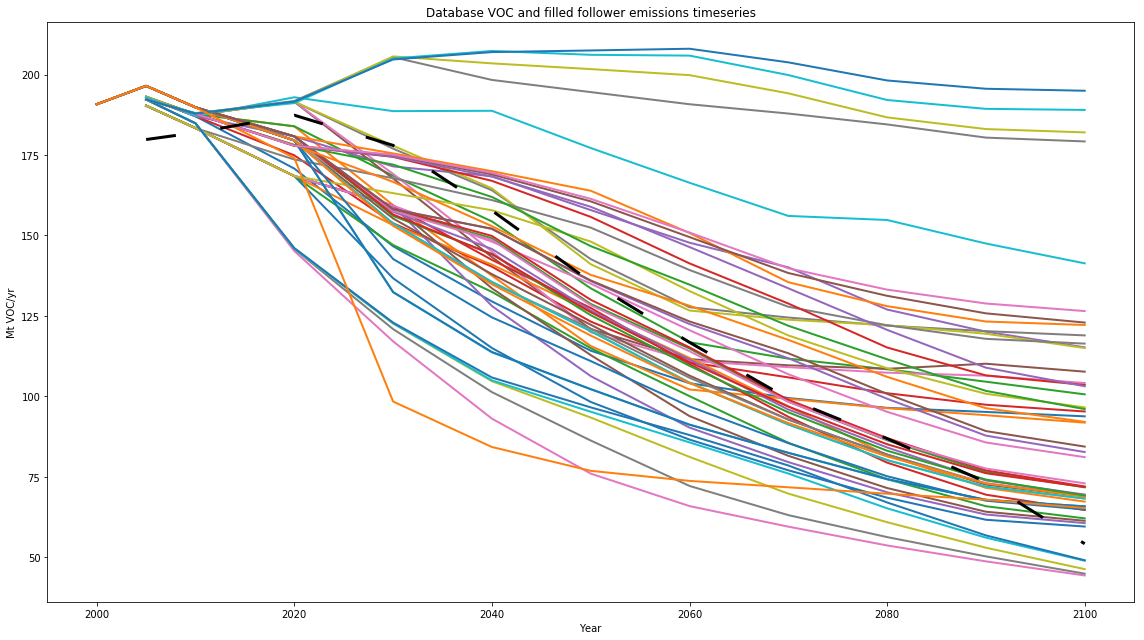

In [16]:
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=False
)
results = filler(filler_data)
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sr15_data_tdr.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
results.filter(variable="*VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), linewidth=3
)
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

In this case, this works well, because the mean CO2 value is always positive and moderately large. However when negatives predominate, allowing values of all signs may make results unstable, as shown below. 

In [17]:
sr15_data_tdr_red = sr15_data_tdr.filter(
    scenario=["*Baseline", "*-60"], keep=False
).filter(scenario="SSP*", keep=True)
cruncher = silicone.database_crunchers.DatabaseCruncherTimeDepRatio(
    sr15_data_tdr_red
)
filler_same_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=True
)
filler_dif_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=False
)
results_same = filler_same_sign(filler_data)
results_dif = filler_dif_sign(filler_data)

c:\users\rlamboll\constraincode\silicone\src\silicone\database_crunchers\time_dep_ratio.py:110: RuntimeWarning: Mean of empty slice
  data_follower[year].iloc[~pos_inds].values
c:\users\rlamboll\constraincode\silicone\src\silicone\database_crunchers\time_dep_ratio.py:111: RuntimeWarning: Mean of empty slice
  ) / np.nanmean(data_leader[year].iloc[~pos_inds].values)


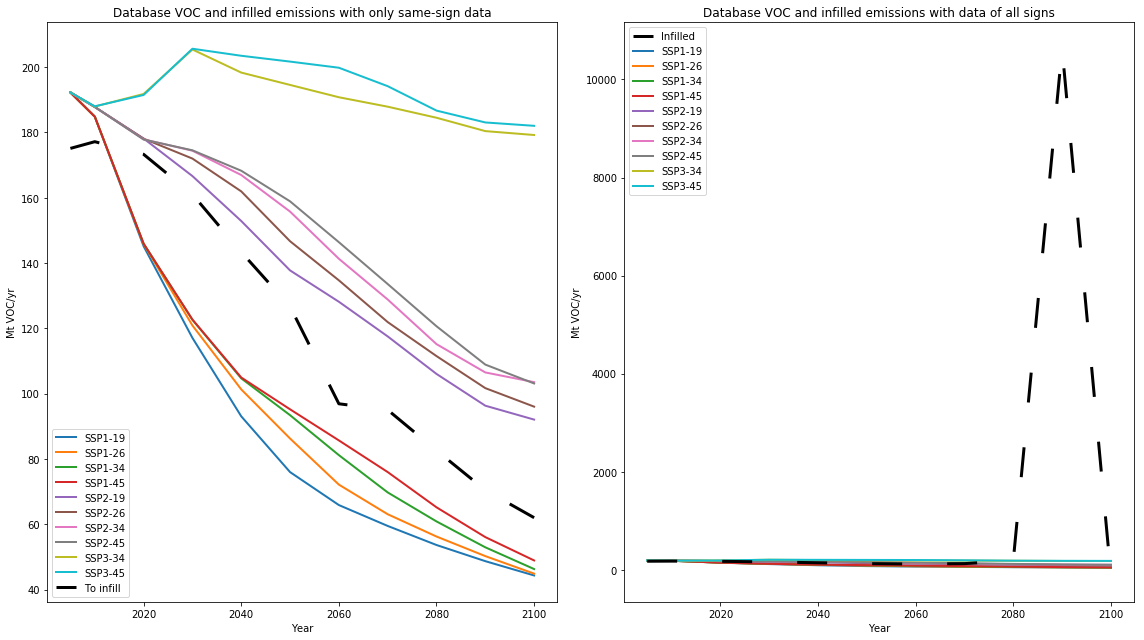

In [18]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr_red.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
results_same.filter(variable="*VOC").line_plot(
    ax=ax,
    color="black",
    linestyle="--",
    dashes=(10, 15),
    linewidth=3,
    label="To infill",
)
ax.set_title("Database VOC and infilled emissions with only same-sign data")
ax = fig.add_subplot(122)
sr15_data_tdr_red.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
results_dif.filter(variable="*VOC").line_plot(
    ax=ax,
    color="black",
    linestyle="--",
    dashes=(10, 15),
    linewidth=3,
    label="Infilled",
)
ax.set_title("Database VOC and infilled emissions with data of all signs")

plt.tight_layout()

If all of the infiller database has a different sign to the infillee lead, same_sign cannot be used and will present an error:

In [19]:
sr15_data_tdr_red = sr15_data_tdr.filter(
    scenario=["SSP1-19", "SSP1-26"], keep=True
)
# These are cases where CO2 goes negative
cruncher = silicone.database_crunchers.DatabaseCruncherTimeDepRatio(
    sr15_data_tdr_red
)
filler_same_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=True
)
try:
    results_same = filler_same_sign(filler_data)
except ValueError as e:
    print(e)

Attempt to infill ['Emissions|CO2'] data using the time_dep_ratio cruncher where the infillee data has a sign not seen in the infiller database for year 2080.


c:\users\rlamboll\constraincode\silicone\src\silicone\database_crunchers\time_dep_ratio.py:107: RuntimeWarning: Mean of empty slice
  data_follower[year].iloc[pos_inds].values
c:\users\rlamboll\constraincode\silicone\src\silicone\database_crunchers\time_dep_ratio.py:108: RuntimeWarning: Mean of empty slice
  ) / np.nanmean(data_leader[year].iloc[pos_inds].values)


With same_sign = False, no error will be reported but unrealistically high values and negative values will be returned:

In [20]:
filler_dif_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=False
)
results_dif = filler_dif_sign(filler_data)

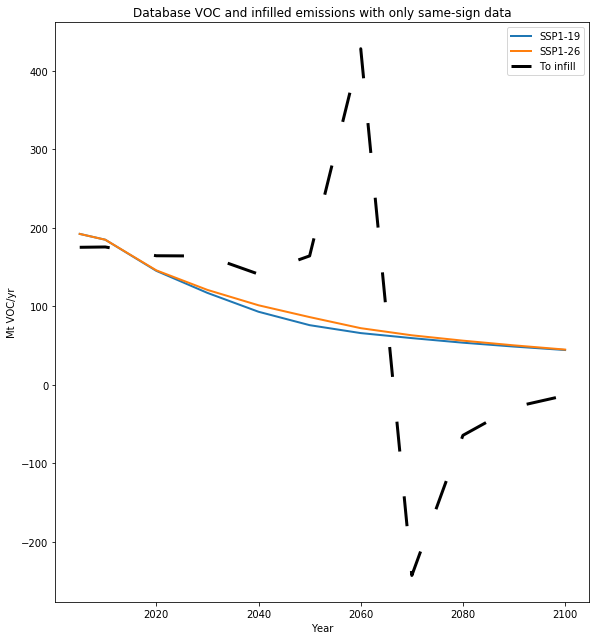

In [21]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr_red.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
results_dif.filter(variable="*VOC").line_plot(
    ax=ax,
    color="black",
    linestyle="--",
    dashes=(10, 15),
    linewidth=3,
    label="To infill",
)
ax.set_title("Database VOC and infilled emissions with only same-sign data")

plt.tight_layout()

### Constant ratio cruncher
This infiller simply multiples the lead emissions by a constant, which it must be told. It must also be told the units of the value it returns. It does not require an input infiller dataframe. This is mostly used in cases where we have very limited knowledge of a gas (perhaps it does not appear in the other databases) but project that it is proportional to another gas. It can also be used to infill 0s in the concentrations of gases with negligible concentrations. 

In [22]:
print(silicone.database_crunchers.DatabaseCruncherConstantRatio.__doc__)


    Database cruncher which uses the 'constant given ratio' technique.

    This cruncher does not require a database upon initialisation. Instead, it requires
    a constant and a unit to be input when deriving relations. This constant,
    :math:`s`, is the ratio of the follower variable to the lead variable i.e.:

    .. math::

        E_f(t) = s * E_l(t)

    where :math:`E_f(t)` is emissions of the follower variable and :math:`E_l(t)` is
    emissions of the lead variable.
    


In [23]:
cruncher = (
    silicone.database_crunchers.DatabaseCruncherConstantRatio()
)  # No input needed.
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], 0.5, "kt VOC/yr"
)
print(filler.__doc__)


            Filler function derived from :obj:`DatabaseCruncherTimeDepRatio`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled-in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf``.
            


In [24]:
sr15_data_cr = sr15_data.filter(
    model="MESSAGE-GLOBIOM*", scenario="SSP2*", variable="Emissions|CO2"
)
infilled = filler(sr15_data_cr)
infilled.head()

,model,scenario,region,variable,unit,year,subannual,meta,value
144651,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2005,0.0,0,18883.620915
144652,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2010,0.0,0,20156.751015
144653,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2020,0.0,0,20465.660870
144654,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2030,0.0,0,11816.564265
144655,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2040,0.0,0,5762.064700


Text(0.5, 1.0, 'Database CO2 and lead emissions timeseries')

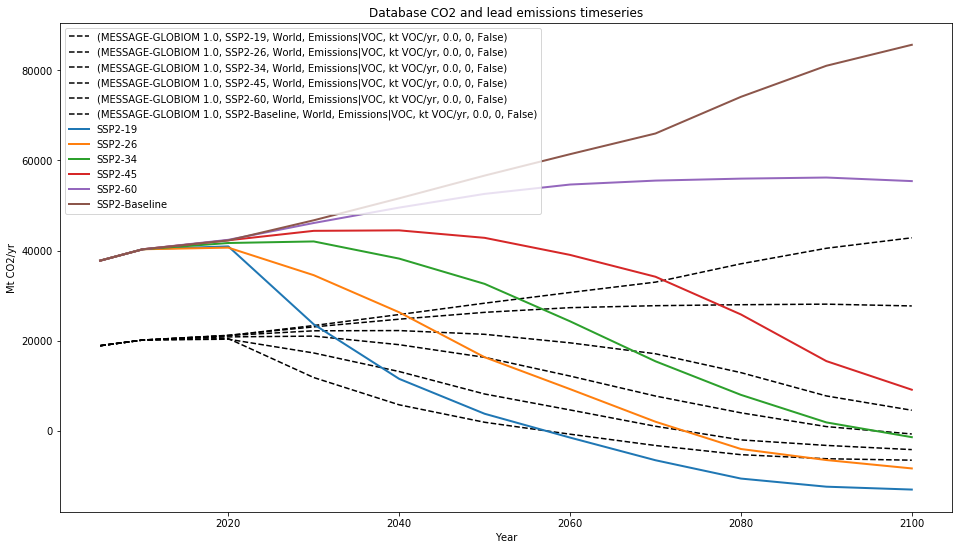

In [25]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
infilled.line_plot(ax=ax, color="black", linestyle="--")
sr15_data_cr.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
ax.set_title("Database CO2 and lead emissions timeseries")

This straightforwardly adds another series in fixed ratio and different units, as expected. 

## Interpolate specified scenarios and models

This cruncher simply interpolates a straight line between the points in the plot of all leader and all follower. It has a wrapper that pre-filters the infiller data to such that it only uses data from scenarios or models containing a specified string (typically scenarios which start with "SSP"). This can be done with any of the models by filtering the data before it is put in, but is explicitly included as a possible parameter in this cruncher because here more data makes the cruncher more chaotic, whereas most crunchers benefit from more data. 

In [26]:
print(
    silicone.database_crunchers.DatabaseCruncherScenarioAndModelSpecificInterpolate.__doc__
)


    Database cruncher which pre-filters to only use data from specific scenarios, then
    runs the linear interpolator to return values from that set of scenarios. See the
    documentation of DatabaseCruncherLinearInterpolation for more details.
    


In [27]:
# The above is a reference to this cruncher, which can be easier to use if you filter your infiller data anyway:
print(silicone.database_crunchers.DatabaseCruncherLinearInterpolation.__doc__)


    Database cruncher which uses linear interpolation.

    This cruncher derives the relationship between two variables by simply linearly
    interpolating between values in the cruncher database. It does not do any smoothing
    and is best-suited for smaller databases.

    In the case where there is more than one value of the follower variable for a
    given value of the leader variable, the average will be used. For example, if
    one scenario has CH4 emissions of 10 MtCH4/yr whilst another has CH4
    emissions of 20 MtCH4/yr in 2020 whilst both scenarios have CO2 emissions
    of exactly 15 GtC/yr in 2020, the interpolation will use the average value from the
    two scenarios i.e. 15 Mt CH4/yr.

    Beyond the bounds of input data, the linear interpolation is held constant.
    For example, if the maximum CO2 emissions in 2020 in the database is
    25 GtC/yr, and CH4 emissions for this level of CO2 emissions are 15 MtCH4/yr,
    then even if we infill using a CO2 emissions

### Using only one model

We will compare infilling using a database comprised of data only from variants of the MESSAGE models against AIM models. 

In [28]:
sr15_data_message = sr15_data.filter(
    model=["MESSAGE*"],
    variable=[
        "Emissions|CO2",
        "Emissions|VOC",
        "Emissions|CH4",
        "Emissions|HCF*",
    ],
)
sr15_data_message.models()

0              MESSAGE V.3
1      MESSAGE-GLOBIOM 1.0
2    MESSAGEix-GLOBIOM 1.0
Name: model, dtype: object

As we see below, variants of the MESSAGE model have submitted data for a large number of scenarios.

In [29]:
len(sr15_data_message.scenarios())

58

For our example, we will infill data using data taken only from variants of the AIM model and we are only going to infill data for variants of SSP2.

In [30]:
sr15_data_aim_ssp2 = sr15_data.filter(
    model=["AIM*"],
    scenario="SSP2*",
    variable=[
        "Emissions|CO2",
        "Emissions|VOC",
        "Emissions|CH4",
        "Emissions|HCF*",
    ],
    year=sr15_data_message.data["year"].unique(),
)
sr15_data_aim_ssp2.models()

0    AIM/CGE 2.0
Name: model, dtype: object

In [31]:
len(sr15_data_aim_ssp2.scenarios())

6

Although the lineshapes for CO$_2$ (left-hand column below) look similar in the AIM and MESSAGE models, the lineshapes for VOC (right-hand column below) are very different. 

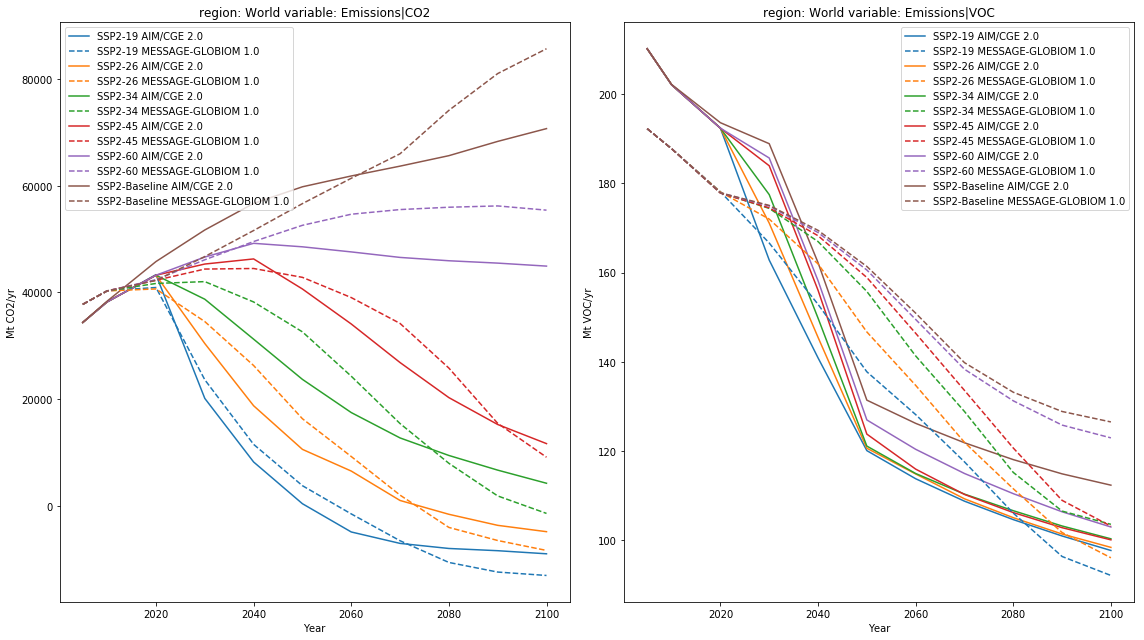

In [32]:
pdf = pyam.concat([sr15_data_message, sr15_data_aim_ssp2])

fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(121)
pdf.filter(scenario="SSP2*", variable="*CO2").line_plot(
    ax=ax, color="scenario", linestyle="model"
)

ax = fig.add_subplot(122)
pdf.filter(scenario="SSP2*", variable="*VOC").line_plot(
    ax=ax, color="scenario", linestyle="model"
)

plt.tight_layout()

Variants of the MESSAGE model have submitted data for many scenarios, but this cruncher allows us to specify that only data from scenarios which start with SSP2 should be used. 

In [33]:
cruncher = silicone.database_crunchers.DatabaseCruncherScenarioAndModelSpecificInterpolate(
    sr15_data_message
)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], required_scenario="SSP2*"
)
infilled = filler(sr15_data_aim_ssp2)

We can now compare the original data, the database which was used to derive the infilling relationship and the infilled data. We see that the infilled results result in timeseries which much more strongly resemble the timeseries in the database (i.e. the similarity in CO$_2$ emissions is now also reflected in VOC emissions). We also see that no emissions values more extreme than the range of values contained in the input database are returned by this cruncher.

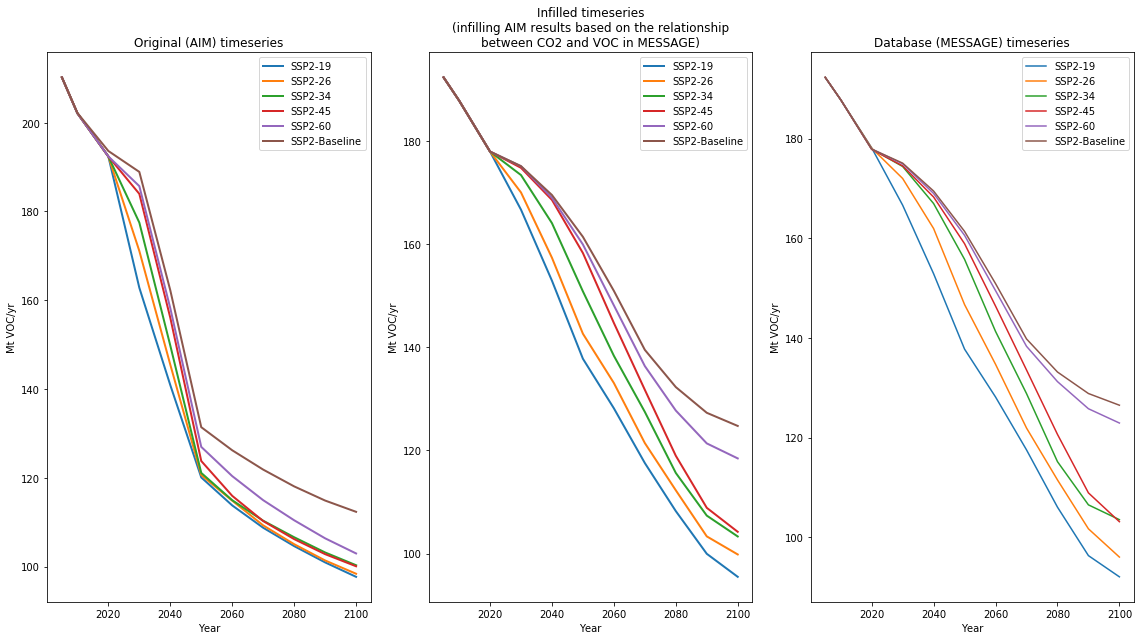

In [34]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(131)
sr15_data_aim_ssp2.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
ax.set_title("Original (AIM) timeseries")

ax = fig.add_subplot(132)
infilled.line_plot(ax=ax, **pkwargs)
ax.set_title(
    "Infilled timeseries\n(infilling AIM results based on the relationship\nbetween CO2 and VOC in MESSAGE)"
)

ax = fig.add_subplot(133)
sr15_data_message.filter(scenario="SSP2*", variable="*VOC").line_plot(
    ax=ax, color="scenario"
)
ax.set_title("Database (MESSAGE) timeseries")

plt.tight_layout()

We see that the infilled values strongly resembles the infiller data in terms of lineshape, and is constrained between the highest and lowest values of the infiller database at that time. 

### Multiple models

However, if we include data from many different models in our database, the inter-model differences often exceed the differences within a single model's data, making for rather chaotic interpolation between closely-spaced points in the leader variable. This is shown below. 

In [35]:
# We take all data except AIM:
scenario_string = "SSP2*"
too_much_data = sr15_data.filter(
    variable=[
        "Emissions|CO2",
        "Emissions|VOC",
        "Emissions|CH4",
        "Emissions|HCF*",
    ]
).filter(model=["AIM*"], keep=False)


cruncher = silicone.database_crunchers.DatabaseCruncherScenarioAndModelSpecificInterpolate(
    too_much_data
)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], required_scenario=scenario_string
)

infilled = filler(sr15_data_aim_ssp2)
# The following functions are not of general interest, and are used here to expose the inner workings of the infiller
wide_db = _make_wide_db(too_much_data.filter(scenario=scenario_string))
interpolator = _make_interpolator(
    "Emissions|VOC", ["Emissions|CO2"], wide_db, "year"
)

There is no simple function relating the CO$_2$ and VOC trends in this case. Take the example year of 2060:

Text(0, 0.5, 'Mt VOC/yr')

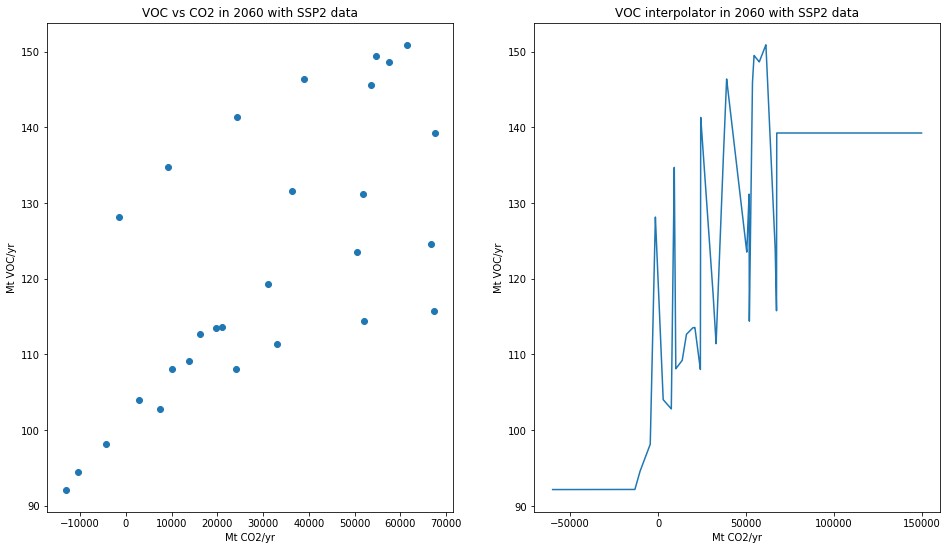

In [36]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
plt.scatter(
    wide_db["Emissions|CO2"].loc[
        wide_db.index.get_level_values("year") == 2060
    ],
    wide_db["Emissions|VOC"].loc[
        wide_db.index.get_level_values("year") == 2060
    ],
)
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")
ax.set_title("VOC vs CO2 in 2060 with SSP2 data")
ax = fig.add_subplot(122)

xs = np.arange(-60000, 150000)
plt.plot(xs, interpolator[2060](xs))
plt.title("VOC interpolator in 2060 with SSP2 data")
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")

This results in surprising and noisy trend lines in the infilled data:

Text(0.5, 1.0, 'Infilled VOC trends')

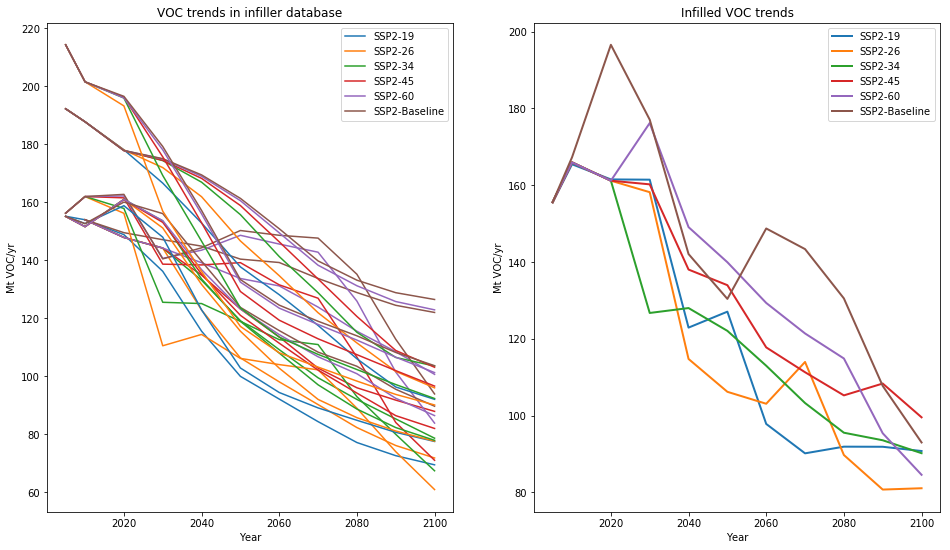

In [37]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(121)
too_much_data.filter(scenario="SSP2*", variable="*VOC").line_plot(
    ax=ax, color="scenario"
)
ax.set_title("VOC trends in infiller database")

ax = fig.add_subplot(122)
infilled.line_plot(ax=ax, **pkwargs)
ax.set_title("Infilled VOC trends")

By contrast, if we choose only the baseline, we get more regular results, albeit with a strong discontinuity. 

In [38]:
baseline = "SSP2-Baseline"
less_data = too_much_data.filter(scenario=baseline)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], required_scenario=baseline
)
infilled = filler(sr15_data_aim_ssp2)

In [39]:
wide_db = _make_wide_db(less_data)
interpolator = _make_interpolator(
    "Emissions|VOC", ["Emissions|CO2"], wide_db, "year"
)

Text(0, 0.5, 'Mt VOC/yr')

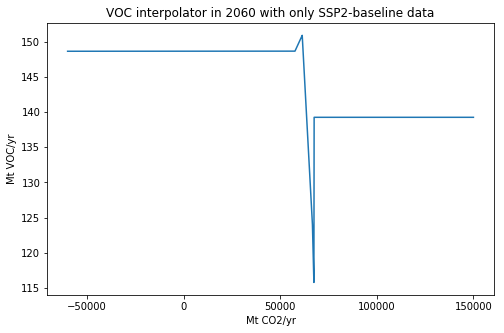

In [40]:
fig = plt.figure(figsize=(8, 5))

xs = np.arange(-60000, 150000)
plt.plot(xs, interpolator[2060](xs))
plt.title("VOC interpolator in 2060 with only SSP2-baseline data")
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")

We see the results of this are less chaotic, but more deterministic (most possible values of CO2 are mapped to one of two values). 

Text(0.5, 1.0, 'Infilled VOC trends')

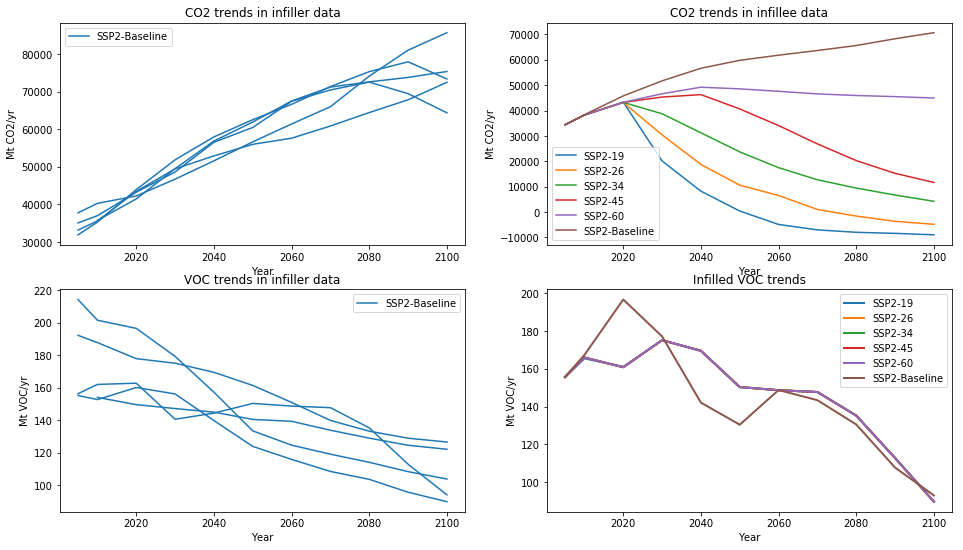

In [41]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(221)
less_data.filter(scenario=baseline, variable="*CO2").line_plot(
    ax=ax, color="scenario"
)
ax.set_title("CO2 trends in infiller data")

ax = fig.add_subplot(222)
sr15_data_aim_ssp2.filter(variable="*CO2").line_plot(ax=ax, color="scenario")
ax.set_title("CO2 trends in infillee data")

ax = fig.add_subplot(223)
less_data.filter(scenario=baseline, variable="*VOC").line_plot(
    ax=ax, color="scenario"
)
ax.set_title("VOC trends in infiller data")

ax = fig.add_subplot(224)
infilled.line_plot(ax=ax, **pkwargs)
ax.set_title("Infilled VOC trends")

We see that the results are all one of two timeseries, but still irregular. This shows that this is generally not an appropriate model to use unless the infiller model has strong similarities with some specific subset of models or scenarios, and usually we will require both to be restricted. 